In [1]:
import numpy as np
from numpy import float64 as realN

from DaTaReachControl.overapprox_functions import *
from DaTaReachControl.interval import *
from numba import jit, typeof, typed

from DaTaReachControl.reach import *
from DaTaReachControl import generateTraj, synthNextState, synthTraj

import time
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Define the Unicycle system dynamics and the initial trajectory is generated
# randomnly from the data

# Define a seed for repeatability
np.random.seed(3338) # 801, 994, 3338
# val = int(np.random.uniform(0,4000))
# print (val)
# np.random.seed(val)

# Sampling time
sampling_time = 0.1

# Define the initial satte and the axis limits
initial_state = np.array([-2, -2.5, np.pi/2])

# Number of data in initial trajectory
n_data_max = 20

# max number of iteration
max_iteration = 70 - n_data_max

################### Input bounds  #################################
v_max = 4
w_max = 0.5 * (2*np.pi)
v_min = -v_max
w_min = -w_max
input_lb = np.array([v_min, w_min])
input_ub = np.array([v_max, w_max])

# Generate input sequence
v_seq = -1 *(np.random.rand(n_data_max,1) - 0) * v_max       # Go only backwards
w_seq = 2 * (np.random.rand(n_data_max,1) - 0.5) * w_max
nSep = int(n_data_max /2)
sepIndexes = np.random.choice([ i for i in range(n_data_max)], nSep, replace=False)
# The trajectory should try system response in each control direction
w_seq[0,0] = 0.0 #
v_seq[0,0] = 0.0
for i in range(1,nSep):
    v_or_theta = np.random.randint(0,2)
    if v_or_theta == 0: # pick v
        w_seq[sepIndexes[i],0] = 0
    else: # pick theta
        v_seq[sepIndexes[i],0] = 0
rand_init_input_vec = np.hstack((v_seq,w_seq))
# print (rand_init_input_vec)
###################################################################

# Generate the random trajectory corresponding to random input sequence
rand_init_traj_vec = np.zeros((n_data_max + 1, initial_state.size))
rand_init_traj_der_vec = np.zeros((n_data_max, initial_state.size))
#######################################################################

# Input signal for the reachable set computation
c_vmax = rand_init_input_vec[-1,0] * -0.5
c_wmax = rand_init_input_vec[-1,1] * 0.3
c_rot = 6
t_end = (n_data_max-1) * sampling_time

@jit(nopython=True, parallel=False, fastmath=True)
def uOver(t_lb, t_ub):
    if t_lb <= t_end+(0.9*sampling_time):
        indx = int(t_lb / sampling_time)
        return rand_init_input_vec[indx,:], rand_init_input_vec[indx,:] 
    x_lb = np.empty(2, dtype=realN)
    x_ub = np.empty(2, dtype=realN)
    x_lb[0] = c_vmax
    x_ub[0] = c_vmax
    x_lb[1], x_ub[1] = cos_i(c_rot*(t_lb-t_end), c_rot*(t_ub-t_end))
    x_lb[1], x_ub[1] = mul_i_scalar(x_lb[1], x_ub[1], c_wmax)
    return x_lb, x_ub

@jit(nopython=True, parallel=False, fastmath=True)
def uOverDer(t_lb, t_ub):
    x_lb = np.zeros(2, dtype=realN)
    x_ub = np.zeros(2, dtype=realN)
    if t_lb <= t_end+(0.9*sampling_time):
        return x_lb, x_ub
    x_lb[1], x_ub[1] = sin_i(c_rot*(t_lb-t_end), c_rot*(t_ub-t_end))
    x_lb[1], x_ub[1] = mul_i_scalar(x_lb[1], x_ub[1], -c_wmax * c_rot)
    return x_lb, x_ub

#######################################################################

########################### Unknown dynamic ###########################
def fFun(x):
    return np.zeros(3)
def GFun(x):
    return np.array([[np.cos(x[2]), 0], [np.sin(x[2]), 0], [0.0, 1.0]])
def uFun(t):
    u_t, _ = uOver(t, t)
    return u_t.reshape(-1,1)
#######################################################################

# Generate a trajectory and use it to compare the over-approximation by
# the new algorithm and the old algorithm
nPoint = 81
dt = 0.05
# Create the time tables
tVal_1 = np.array([ i*dt for i in range(nPoint+1)])
tMeas = np.array([i*sampling_time for i in range(rand_init_traj_der_vec.shape[0])])
# Obtain the trajectory via ode solver
tVal_1, traj, trajDot = synthTraj(fFun, GFun, uFun, initial_state, tVal_1, atol=1e-10, rtol=1e-10)
tVal = tVal_1[:-1]
# New u value for comparison
u_values = np.empty((nPoint, rand_init_input_vec.shape[1]))
# Create the u table by first adding the u applied during the trajectory
# used to learn the dynamics
repeat_val = int(sampling_time/dt)
for i in range(u_values.shape[0]):
    t_lb, t_ub = uOver(tVal[i], tVal[i])
    u_values[i,:] = t_lb

# Construct the state evolution and the state derivative evolution
x_values = traj.T[:,:]
xdot_values = trajDot.T[:-1,:]

# Now redefine the state and theur derivative
for i in range(0, repeat_val*rand_init_input_vec.shape[0], repeat_val):
    rand_init_input_vec[int(i/repeat_val),:] = u_values[i,:] 
    rand_init_traj_der_vec[int(i/repeat_val),:] = xdot_values[i,:]
    rand_init_traj_vec[int(i/repeat_val),:] = x_values[i,:]
rand_init_traj_vec[-1,:] = x_values[repeat_val*rand_init_input_vec.shape[0],:]

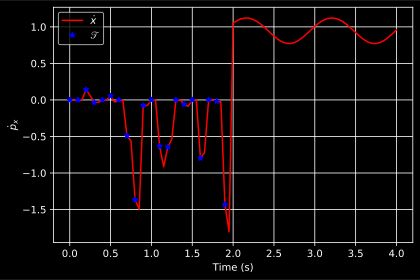

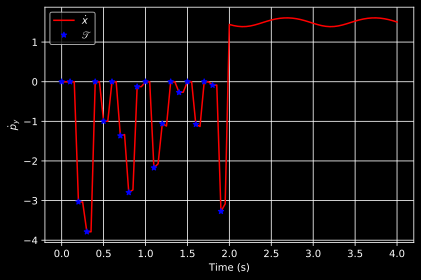

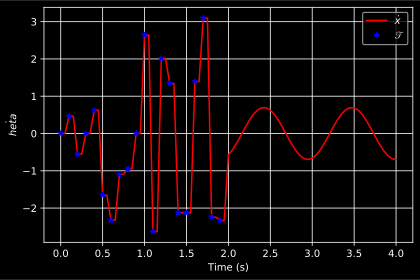

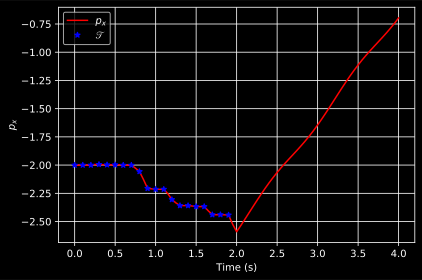

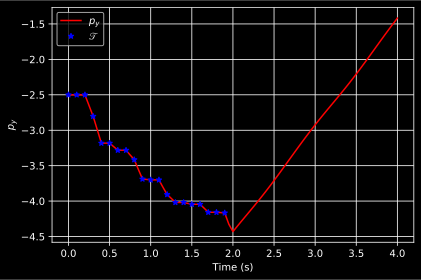

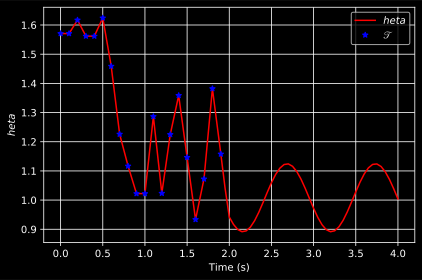

In [3]:
# Preview the trajectory
plt.style.use('dark_background')
yaxis_label  = ['$\dot{p}_x$', '$\dot{p}_y$', '$\dot{\theta}$']
stateLabel  = ['$p_x$', '$p_y$', '$\theta$']
label_name  = ['$\dot{x}$', '$\mathrm{HC4revise}$', '$\mathrm{ExcitationBased}$']
for i in range(xdot_values.shape[1]):
    plt.figure()
    plt.plot(tVal, xdot_values[:,i], "red", label='$\dot{x}$')
    plt.plot(tMeas, rand_init_traj_der_vec[:,i], 'b*', label='$\mathscr{T}$')
    plt.xlabel('Time (s)')
    plt.ylabel(yaxis_label[i])
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for i in range(xdot_values.shape[1]):
    plt.figure()
    plt.plot(tVal, x_values[:-1,i], "red", label=stateLabel[i])
    plt.plot(tMeas, rand_init_traj_vec[:-1,i], 'b*', label='$\mathscr{T}$')
    plt.xlabel('Time (s)')
    plt.ylabel(stateLabel[i])
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
Lf = np.array([0, 0, 0], dtype=realN)
LG = np.array([[1,0],[1,0],[0,0]], dtype=realN)
bG = Dict(*depTypebG)
bG[(0,0)] = (-1.0,1.0)
bG[(1,0)] = (-1.0,1.0)

nDepG = Dict(*depTypeG)
nDepG[(0,0)] = np.array([0,1],dtype=np.int64)
nDepG[(1,0)] = np.array([0,1],dtype=np.int64)

@jit(nopython=True)
def knownGfun(x_lb, x_ub):
    res_lb = np.zeros((3,2),dtype=realN)
    res_ub = np.zeros((3,2),dtype=realN)
    res_lb[2,1] = 1
    res_ub[2,1] = 1
    # res_lb[0,0], res_ub[0,0] = cos_i(x_lb[2], x_ub[2])
    return res_lb, res_ub

overApprox = initOverApprox(Lf, LG,  Lfknown=None, LGknown=None, nvDepF=depTypeF,
        nvDepG=nDepG, bf=depTypebf , bG =bG , bGf = depTypeGradF,
        bGG=depTypeGradG, xTraj=rand_init_traj_vec,
        xDotTraj=rand_init_traj_der_vec, uTraj=rand_init_input_vec,
        useGronwall=True, verbose=False, Gknown=knownGfun)

In [5]:
canApproximate(overApprox)

(True, True)

In [6]:
# Compute the different over-approximation
@jit(nopython=True, parallel=False, fastmath=True)
def h_numba(approxObj):
    res_lb = np.zeros((nPoint, x_values.shape[1]))
    res_ub = np.zeros((nPoint, x_values.shape[1]))
    for i in range(nPoint):
        f_lb, f_ub = fover(approxObj, x_values[i,:], x_values[i,:])
        G_lb, G_ub = Gover(approxObj, x_values[i,:], x_values[i,:], knownG=knownGfun)
        res_lb[i,:], res_ub[i,:] = add_i(f_lb, f_ub, *mul_Ms_i(G_lb, G_ub, u_values[i,:]))
    return res_lb, res_ub

In [7]:
resn_lb, resn_ub =  h_numba(overApprox)
s_time = time.time()
resn_lb, resn_ub =  h_numba(overApprox)
print(time.time() - s_time)

0.0027887821197509766


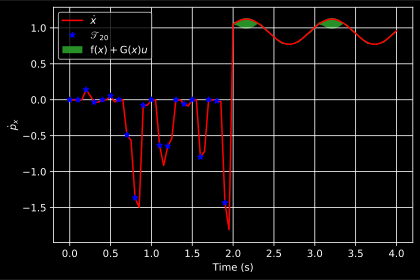

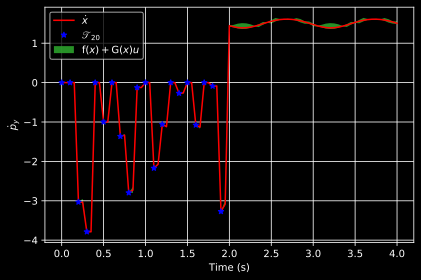

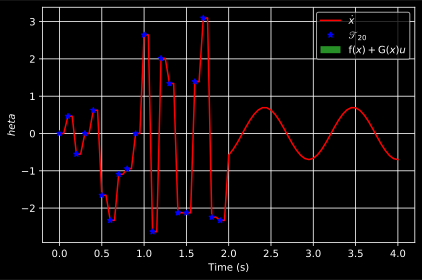

In [8]:
plt.style.use('dark_background')
yaxis_label  = ['$\dot{p}_x$', '$\dot{p}_y$', '$\theta$']
zoomInd = rand_init_input_vec.shape[0]*repeat_val
for i in range(xdot_values.shape[1]):
    plt.figure()
    plt.plot(tVal, xdot_values[:,i], "red", label='$\dot{x}$')
    plt.plot(tMeas, rand_init_traj_der_vec[:,i], 'b*', label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
    plt.fill_between(tVal, resn_lb[:,i], resn_ub[:,i], alpha=0.9, facecolor='tab:green', label='$\mathrm{f}(x) + \mathrm{G}(x) u$')
    plt.xlabel('Time (s)')
    plt.ylabel(yaxis_label[i])
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [9]:
# Discretization for the reachable sets computation
dt_reach = 0.05
@jit(nopython=True, parallel=False, fastmath=True)
def reachSet(overApprox):
    res_lb = np.empty((x_values.shape[0]+1, x_values.shape[1]), dtype=realN)
    res_ub = np.empty((x_values.shape[0]+1, x_values.shape[1]), dtype=realN)
    res_lb[0,:] = rand_init_traj_vec[0,:]
    res_ub[0,:] = rand_init_traj_vec[0,:]
    for i in range(rand_init_input_vec.shape[0]):
        curr_x = rand_init_traj_vec[i,:]
        curr_u = rand_init_input_vec[i,:]
        _, x_lb, x_ub = DaTaReach(overApprox, curr_x, curr_x, tMeas[i], repeat_val, dt, 
                                uOver, uOverDer, knownG=knownGfun)
        for p in range(repeat_val):
            res_lb[i*repeat_val+p+1,:] = x_lb[p+1,:]
            res_ub[i*repeat_val+p+1,:] = x_ub[p+1,:]
    _, x_lb, x_ub = DaTaReach(overApprox, rand_init_traj_vec[-1,:], rand_init_traj_vec[-1,:], 
                        t_end+sampling_time, x_values.shape[0]-repeat_val*rand_init_input_vec.shape[0], 
                        dt, uOver, uOverDer, knownG=knownGfun)
    for p in range(x_lb.shape[0]-1):
        res_lb[repeat_val*rand_init_input_vec.shape[0]+p+1,:] = x_lb[p+1,:]
        res_ub[repeat_val*rand_init_input_vec.shape[0]+p+1,:] = x_ub[p+1,:]
    return res_lb, res_ub    
_,_ = reachSet(overApprox)

In [10]:
# COmpute the over-approximations
s_time = time.time()
reachn_lb, reachn_ub =  reachSet(overApprox)
print(time.time() - s_time)

0.013823747634887695


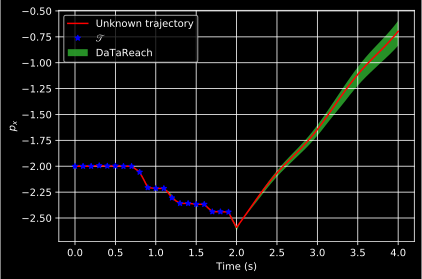

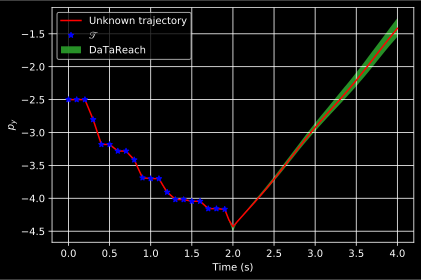

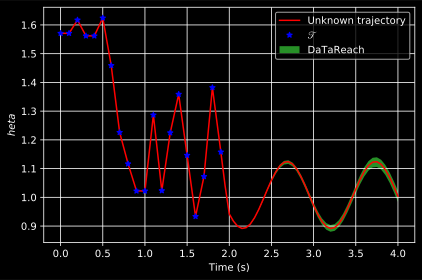

In [11]:
# Preview the trajectory
plt.style.use('dark_background')
stateLabel  = ['$p_x$', '$p_y$', '$\theta$']

for i in range(xdot_values.shape[1]):
    plt.figure()
    plt.plot(tVal, x_values[:-1,i], "red", label='$\mathrm{Unknown\ trajectory}$')
    plt.plot(tMeas, rand_init_traj_vec[:-1,i], 'b*', label='$\mathscr{T}$')
    plt.fill_between(tVal, reachn_lb[:-2,i], reachn_ub[:-2,i], alpha=0.9, facecolor='tab:green', label='$\mathrm{DaTaReach}$')
    plt.xlabel('Time (s)')
    plt.ylabel(stateLabel[i])
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

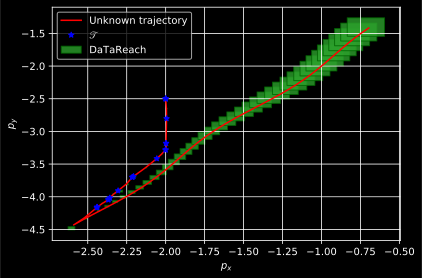

In [12]:
# Proceed to the 2-D plot of the trajectory
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure()
plt.plot(x_values[:-1,0], x_values[:-1,1], 'red', label='$\mathrm{Unknown\ trajectory}$')
plt.plot(rand_init_traj_vec[:-1,0], rand_init_traj_vec[:-1,1], 'b*', label='$\mathscr{T}$')

first = True
for i in range(tVal.shape[0]):
    x1,x2,y1,y2 = reachn_lb[i,0], reachn_ub[i,0], reachn_lb[i,1], reachn_ub[i,1]
    if first:
        plt.fill([x1,x2,x2,x1], [y1,y1,y2,y2],\
                facecolor='tab:green', edgecolor='darkgreen', alpha=0.8,\
                label='$\mathrm{DaTaReach}$')
        first = False
    plt.fill([x1,x2,x2,x1], [y1,y1,y2,y2],\
        facecolor='tab:green', edgecolor='darkgreen', alpha=0.8)
    
plt.xlabel('$p_x$')
plt.ylabel('$p_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()